In [86]:
import os
import dotenv

import pandas as pd
import pandahouse as ph
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

dotenv.load_dotenv()
connection = {'host': os.getenv('host'),
                      'database':os.getenv('database'),
                      'user':os.getenv('user'), 
                      'password':os.getenv('password')
                     }

DAU_query = '''
SELECT toStartOfDay(toDateTime(time)) AS date,
       count(DISTINCT user_id) AS "unique_users"
FROM simulator_20230320.feed_actions

GROUP BY toStartOfDay(toDateTime(time))
ORDER BY "date"
LIMIT 50000;'''

DAU = ph.read_clickhouse(DAU_query, connection=connection)


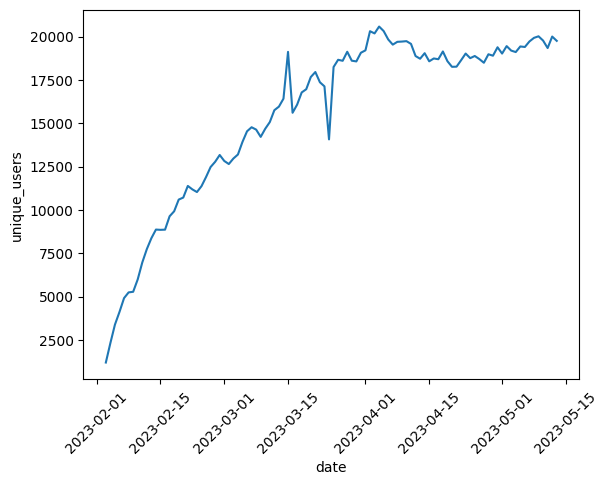

In [87]:
plot = sns.lineplot(data=DAU, x="date", y="unique_users")
plt.setp(plot.get_xticklabels(), rotation=45)
plt.show()

In [88]:
DAU['diff_users'] = DAU['unique_users'].astype(float).diff()
DAU

,date,unique_users,diff_users
0,2023-02-03,1198,NaN
1,2023-02-04,2325,1127.0
2,2023-02-05,3388,1063.0
3,2023-02-06,4121,733.0
4,2023-02-07,4917,796.0
...,...,...,...
95,2023-05-09,20021,90.0
96,2023-05-10,19775,-246.0
97,2023-05-11,19343,-432.0
98,2023-05-12,20006,663.0


In [89]:
DAU.sort_values('diff_users').head(5)

,date,unique_users,diff_users
41,2023-03-16,15609,-3514.0
49,2023-03-24,14073,-3059.0
68,2023-04-12,18882,-701.0
47,2023-03-22,17369,-591.0
75,2023-04-19,18585,-561.0


Мы наблюдаем внезапное падение активной аудитории 2023-03-24! Нужно разобраться, какие пользователи не смогли зайти в приложение, что их объединяет?  

In [90]:
query = '''
select 
    user_id,
    toDate(time) as date,
    country,
    city,
    os,
    source
from {db}.feed_actions
where date between '2023-03-23' and '2023-03-24'
'''
df = ph.read_clickhouse(query, connection=connection)

In [91]:
df.head()

,user_id,date,country,city,os,source
0,9380,2023-03-23,Ukraine,Vinnytsia,Android,ads
1,20034,2023-03-23,Russia,Moscow,iOS,ads
2,40592,2023-03-23,Russia,Saint Petersburg,iOS,ads
3,135380,2023-03-23,Russia,Nazran,Android,organic
4,135380,2023-03-23,Russia,Nazran,Android,organic


Проверим влияние операционной системы на спад пользователей

In [92]:
df.groupby(['date', 'os']).agg({'user_id': 'nunique'})

user_id
date       os              
2023-03-23 Android    11173
           iOS         5959
2023-03-24 Android     9235
           iOS         4838

Выделить какую нибудь os нельзя, проверим влияние страны.

In [93]:
group_country = df.groupby(['date', 'country'], as_index=False).agg({'user_id': 'nunique'})
group_country

,date,country,user_id
0,2023-03-23,Azerbaijan,166
1,2023-03-23,Belarus,343
2,2023-03-23,Cyprus,16
3,2023-03-23,Estonia,23
4,2023-03-23,Finland,164
5,2023-03-23,Kazakhstan,302
6,2023-03-23,Latvia,19
7,2023-03-23,Russia,15075
8,2023-03-23,Switzerland,12
9,2023-03-23,Turkey,160


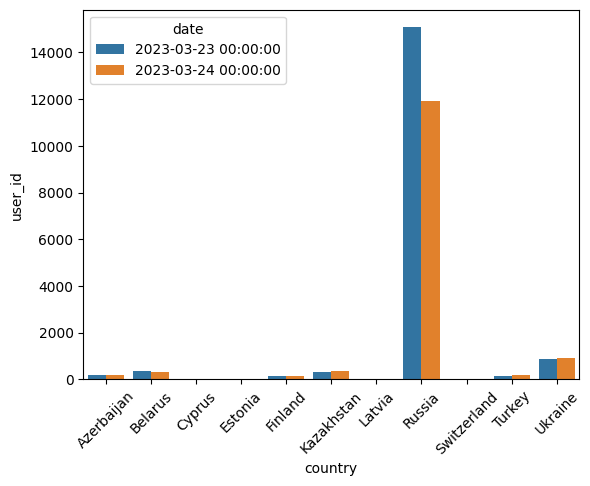

In [94]:
plot = sns.barplot(data = group_country, x = 'country', y = 'user_id', hue = 'date')
plt.setp(plot.get_xticklabels(), rotation=45)
plt.show()

На графике видно что основная масса пользователей не зашедших 24го марта из России. Разберем ее подробнее по городам.

In [95]:
# Перевод даты в более удобный формат
df['date'] = df.date.dt.day

In [96]:
# Посчет активных пользователей в каждом городе
ru_city = df.query('country == "Russia"')\
                .pivot_table(index='city', 
                             columns='date', 
                             values='user_id',
                             aggfunc='nunique',
                            fill_value = 0)\
                .reset_index()
#Посчет разницы между активными пользователями 23 и 24 марта 
ru_city['diff_users'] = ru_city[23] - ru_city[24]

#Сортировка по величине различий
ru_city.sort_values('diff_users', ascending=False)

date,city,23,24,diff_users
841,Moscow,2319,0,2319
1152,Saint Petersburg,764,0,764
957,Novosibirsk,213,0,213
1603,Yekaterinburg,210,0,210
253,Chelyabinsk,195,155,40
...,...,...,...,...
1545,Volgograd,129,147,-18
1159,Samara,160,181,-21
1448,Ulyanovsk,77,102,-25
247,Cheboksary,49,75,-26


Пользователи из Москвы, Санкт-Петербурга, Новосибирска и Екатеринбурга не смогли зайти в приложение 24 марта.